# Visualizations Notebook

## Plots 
## NOTE: Visualizations don't show up on Github
Based on version3 notebook

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import psutil

In [7]:
#!pip install psutil
#!conda install -c plotly plotly-orca


def loss_fig(list_train_loss, list_val_loss):
    """
    Takes in the training and validation loss lists from the train_triangular_policy function
    Outputs Plotly Line plot
    """
    epochs = list(range(1,len(list_train_loss)+1))
    plot_df = pd.DataFrame([epochs,list_train_loss,list_val_loss]).T
    plot_df.columns = ['Epoch','train','validation']
    plot_df.Epoch = plot_df.Epoch.astype(int)
    # Melt so that we can use color
    plot_df = pd.melt(plot_df, id_vars = ['Epoch'], value_vars=['train','validation'])
    plot_df['Loss'] = plot_df['value']
    plot_df['Loss_Type'] = plot_df['variable']
    fig = px.line(plot_df, x="Epoch", y="Loss", color = 'Loss_Type')
    fig.update_layout(title_text='<i><b>Training and Validation Loss</b></i>')
    # Formatting to remove background
    fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        )),
        showlegend=True,
        plot_bgcolor='white'
    )
    fig.show()
    fig.write_image("figures/loss.png")
    #return plot_df

In [8]:
list_train_loss = [0.0036195515633249643,
                     0.0030732007976253203,
                     0.0027680401806791017,
                     0.00289166244922959,
                     0.0026068030481062516,
                     0.0022524417618768784,
                     0.0020494777742916803,
                     0.0019441724427807765,
                     0.0015947578280131637,
                     0.0013650367630771664,
                     0.0011193321851861412,
                     0.0010224538578982177,
                     0.000867897682132192,
                     0.0007443248462456398,
                     0.0005137991790577973,
                     0.0003049691537983462,
                     0.00019629949288069477,
                     0.00015001741254220494,
                     0.00012933272932198718,
                     0.00010251782336463772]
list_val_loss = [0.0035237563360121424,
                 0.00375902624320954,
                 0.0051073724590775076,
                 0.004080788520008837,
                 0.0053610173342519074,
                 0.005373900446338543,
                 0.003874435114853832,
                 0.004272975574720341,
                 0.005065241588827621,
                 0.009876210647523769,
                 0.006574716939958564,
                 0.006467291499762063,
                 0.005835700555938936,
                 0.008785648965506229,
                 0.007083541671573153,
                 0.007049659923239979,
                 0.00833161183134212,
                 0.009276331940475807,
                 0.009388872715898743,
                 0.009509100972695162]
#list_pr_r_f1_cf = [(0.2, 0.1, .3, 0),(0.3, 0.2, .4, 0),(0.4, 0.5, .6, 0),(0.5, 0.6, .7, 0),] # added intialization

loss_fig(list_train_loss, list_val_loss)

In [9]:
def confusion_fig(conf_mat):
    """ Creates a plotly heatmap """
    trace = go.Heatmap(
       x = ['No Pneumonia', 'Pneumonia'],
       y = ['No Pneumonia', 'Pneumonia'],
       z = conf_mat,
       type = 'heatmap',
       colorscale = 'PuBu'
    )
    data = [trace]
    fig = go.Figure(data = data)
    fig.update_xaxes(side="top")
    
    fig.update_layout(title_text='<i><b>Confusion Matrix</b></i>')

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=20),
                        x=0.5,
                        y=1.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))
    
    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=20),
                        x=-0.1,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))
    fig.write_image("figures/conf.png")
    fig.show()

In [10]:
conf_mat = np.array([[8323, 1209],
                       [ 353,  184]])
confusion_fig(conf_mat)

## Conv Layer Visualization
Code Inspired by [Anne Bower's Medium Article](https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb)

In [11]:
import glob
import random
import boto3
import io
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### AWS Image Download

In [12]:
keys = pd.read_table('/Users/nickparker/Desktop/aws_rootkey.csv', header = None)
keys['key'] = keys[0].apply(lambda x: str(x.split('=')[-1]))

session = boto3.Session(
    aws_access_key_id=keys.iloc[0]['key'],
    aws_secret_access_key=keys.iloc[1]['key'],
)

s3 = session.resource('s3')
bucket = s3.Bucket('chestxraylea')

In [13]:
files = [x.key for x in bucket.objects.filter()]
images = [x for x in files if 'png' in x]

In [14]:
images[:10]

['images/00001336_000.png',
 'images/00001337_000.png',
 'images/00001338_000.png',
 'images/00001338_001.png',
 'images/00001338_002.png',
 'images/00001338_003.png',
 'images/00001339_000.png',
 'images/00001340_000.png',
 'images/00001341_000.png',
 'images/00001342_000.png']

In [15]:
# AWS Retrieval not working
image_object = bucket.Object('images/00001338_001.png')
# image = mpimg.imread(io.BytesIO(image_object.get()['Body'].read()), 'png')
# plt.imshow(image, cmap='gray')

### Loading Local Image

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# Neural network with one convolutional layer with four filters
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # Initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # Assumes there are 4 grayscale filters
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
    def forward(self, x):
            # Calculates the output of a convolutional layer pre- and post-activation
            conv_x = self.conv(x)
            activated_x = F.relu(conv_x)

            # Returns both layers
            return conv_x, activated_x
    
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # Grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))
    
    
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])
print('Filter shape: ', filter_vals.shape)

filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3

#filter_2 = np.array([[-1, -1, 1, 1], [-1, 1, 1, -1], [-1, 1, 1, -1], [1, 1, -1, -1]])
#filter_2 = np.array([[-1, -1, -1, 1], [-1, -1, 1, -1], [-1, 1, -1, -1], [1, -1, -1, -1]])
#filter_3 = -1 * filter_2

filters = np.array([filter_1, filter_2, filter_3, filter_4])
# Print out the values of filter 1 as an example
print('Filter 1: \n', filter_1)

# Instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)
# Print out the layer in the network
print(model)

Filter shape:  (4, 4)
Filter 1: 
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]
Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


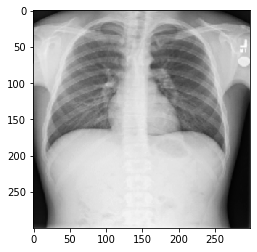

In [22]:
img_path = 'vis_imgs/chest.png'
# Load color image 
bgr_img = cv2.imread(img_path)
# Convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
# Normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255
# Plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

### Conv Layer Output

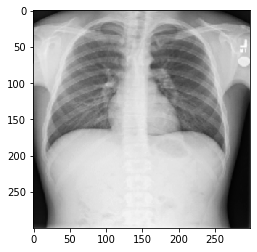

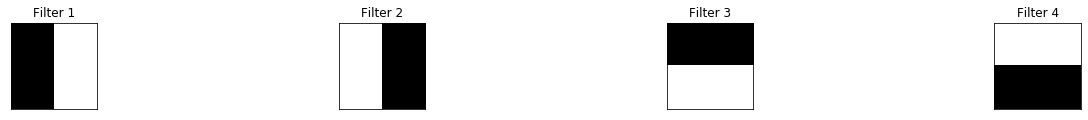

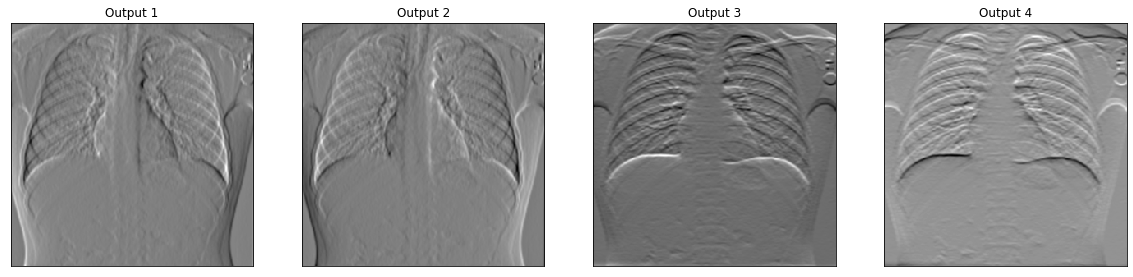

In [23]:
# Plot original image
plt.imshow(gray_img, cmap='gray')
# Visualize all of the filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
# Convert the image into an input tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)
# Get the convolutional layer (pre and post activation)
conv_layer, activated_layer = model(gray_img_tensor)
# Visualize the output of a convolutional layer
viz_layer(conv_layer)


### Sobel Filter - Edge Detection

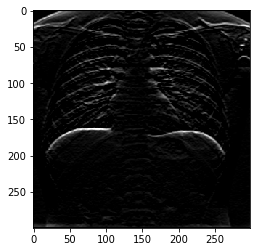

In [24]:
# 3x3 array for edge detection
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])
sobel_x = np.array([[ -1, 0, 1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])
  
filtered_image = cv2.filter2D(gray_img, -1, sobel_y)
plt.imshow(filtered_image, cmap='gray')
# filtered_image = cv2.filter2D(gray_img, -1, sobel_x)
# plt.imshow(filtered_image, cmap='gray')